In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 24.7 MB/s 
     |████████████████████████████████| 895 kB 57.1 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 6.5 MB 57.1 MB/s 
     |████████████████████████████████| 596 kB 57.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import torch
import time
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
fake = pd.read_csv('/content/Fake.csv')


In [ ]:
fake.shape

(23481, 4)

In [ ]:
true = pd.read_csv("/content/True.csv")

In [ ]:
true.shape

(21417, 4)

In [ ]:
# Add flag to track fake and real
fake['target'] = 1
true['target'] = 0

In [ ]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
data.head()

,title,text,subject,date,target
0,Kenya Supreme Court criticizes election board ...,NAIROBI (Reuters) - Kenya s Supreme Court on W...,worldnews,"September 20, 2017",0
1,Trump U.S. antitrust nominee says will be inde...,"WASHINGTON (Reuters) - Makan Delrahim, who was...",politicsNews,"May 10, 2017",0
2,Kellyanne Conway 'inadvertently' plugged Ivank...,WASHINGTON (Reuters) - The White House told a ...,politicsNews,"March 1, 2017",0
3,Death toll from French school bus collision ri...,PARIS (Reuters) - The death toll from a collis...,worldnews,"December 18, 2017",0
4,Israeli PM Netanyahu Quoted In Full Throated ...,Israeli Prime Minister Benjamin Netanyahu has ...,News,"April 15, 2016",1


In [ ]:
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Kenya Supreme Court criticizes election board ...,NAIROBI (Reuters) - Kenya s Supreme Court on W...,worldnews,0
1,Trump U.S. antitrust nominee says will be inde...,"WASHINGTON (Reuters) - Makan Delrahim, who was...",politicsNews,0
2,Kellyanne Conway 'inadvertently' plugged Ivank...,WASHINGTON (Reuters) - The White House told a ...,politicsNews,0
3,Death toll from French school bus collision ri...,PARIS (Reuters) - The death toll from a collis...,worldnews,0
4,Israeli PM Netanyahu Quoted In Full Throated ...,Israeli Prime Minister Benjamin Netanyahu has ...,News,1


In [ ]:
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,NAIROBI (Reuters) - Kenya s Supreme Court on W...,worldnews,0
1,"WASHINGTON (Reuters) - Makan Delrahim, who was...",politicsNews,0
2,WASHINGTON (Reuters) - The White House told a ...,politicsNews,0
3,PARIS (Reuters) - The death toll from a collis...,worldnews,0
4,Israeli Prime Minister Benjamin Netanyahu has ...,News,1


In [ ]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,nairobi (reuters) - kenya s supreme court on w...,worldnews,0
1,"washington (reuters) - makan delrahim, who was...",politicsNews,0
2,washington (reuters) - the white house told a ...,politicsNews,0
3,paris (reuters) - the death toll from a collis...,worldnews,0
4,israeli prime minister benjamin netanyahu has ...,News,1


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

data.head()

,text,subject,target
0,nairobi reuters kenya s supreme court on wedn...,worldnews,0
1,washington reuters makan delrahim who was cho...,politicsNews,0
2,washington reuters the white house told a gov...,politicsNews,0
3,paris reuters the death toll from a collision...,worldnews,0
4,israeli prime minister benjamin netanyahu has ...,News,1


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.head()

,text,subject,target
0,nairobi reuters kenya supreme court wednesday ...,worldnews,0
1,washington reuters makan delrahim chosen presi...,politicsNews,0
2,washington reuters white house told government...,politicsNews,0
3,paris reuters death toll collision train schoo...,worldnews,0
4,israeli prime minister benjamin netanyahu alwa...,News,1


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


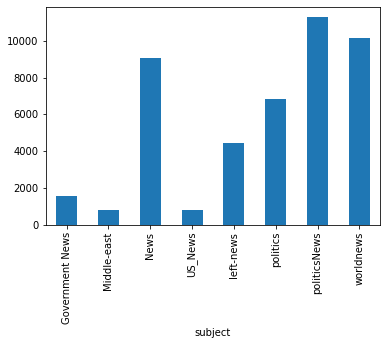

In [ ]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
0    21417
1    23481
Name: text, dtype: int64


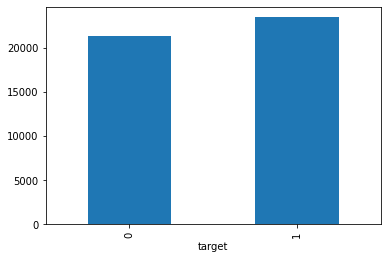

In [ ]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

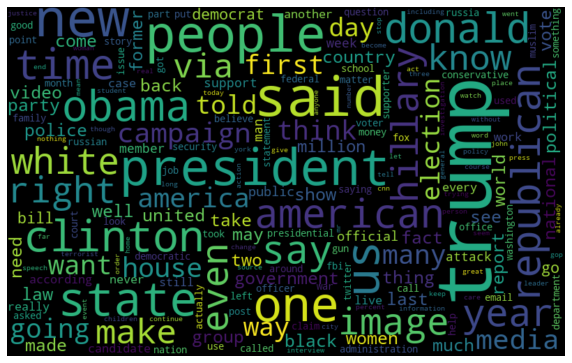

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == 1]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

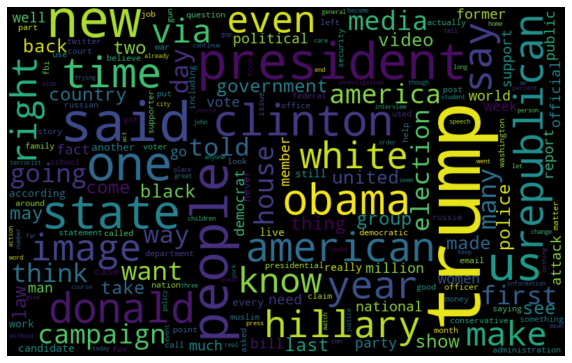

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == 0]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

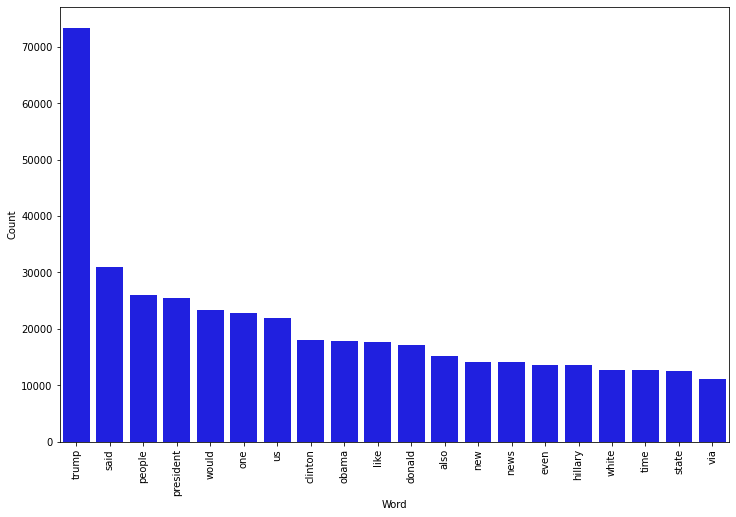

In [ ]:
#Most frequent words in fake news
counter(data[data["target"] == 1], "text", 20)

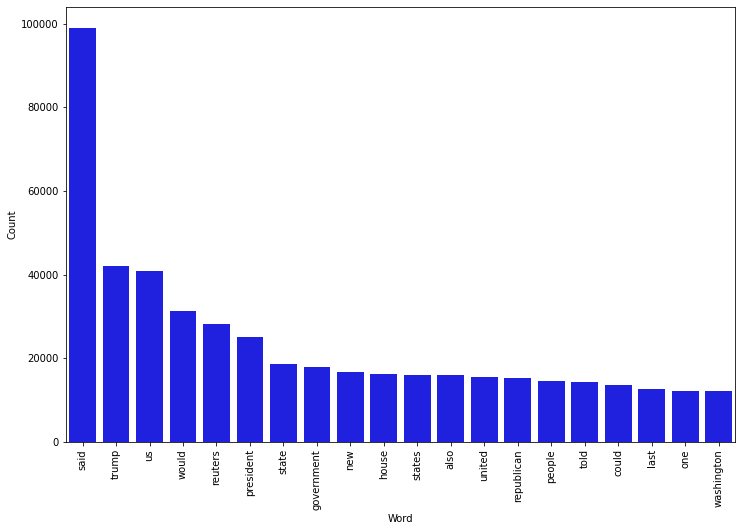

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == 0], "text", 20)

In [ ]:
data.drop(['subject'],axis=1,inplace=True)
data.head()

,text,target
0,nairobi reuters kenya supreme court wednesday ...,0
1,washington reuters makan delrahim chosen presi...,0
2,washington reuters white house told government...,0
3,paris reuters death toll collision train schoo...,0
4,israeli prime minister benjamin netanyahu alwa...,1


In [ ]:
data.head()

,text,target
0,nairobi reuters kenya supreme court wednesday ...,0
1,washington reuters makan delrahim chosen presi...,0
2,washington reuters white house told government...,0
3,paris reuters death toll collision train schoo...,0
4,israeli prime minister benjamin netanyahu alwa...,1


In [ ]:
data.shape

(44898, 2)

In [ ]:
# check class distribution
data['target'].value_counts(normalize = True)

1    0.522985
0    0.477015
Name: target, dtype: float64

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.4, 
                                                                    stratify=data['target'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
test_text

35899    riyadh reuters saudi arabia lifted 35yearold b...
16776    maricopa county sheriff joe arpaio says new vi...
4295     budapest reuters hungarian prime minister vikt...
8830     john kasich became last rival pull campaign ce...
44077    people kinds ways supporting favorite candidat...
                               ...                        
41815    beirut reuters international support group isg...
40066                                    spread everywhere
29662    new york reuters president barack obama said w...
20571    hypocrisy beat hypocrisiesas know donald trump...
27659    borderless travel europe dying political victi...
Name: text, Length: 8980, dtype: object

In [ ]:
print(type(test_text))
print(type(test_labels))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a bert model for fake news detection", "will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 2005, 8275, 2739, 10788, 102], [101, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


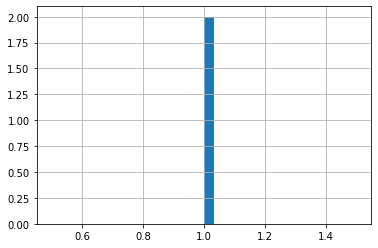

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced',classes= np.unique(train_labels),y= train_labels)

print(class_wts)

[1.04817121 0.9560619 ]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

 #returns the loss and predictions
  return avg_loss, total_preds


In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    842.
  Batch   100  of    842.
  Batch   150  of    842.
  Batch   200  of    842.
  Batch   250  of    842.
  Batch   300  of    842.
  Batch   350  of    842.
  Batch   400  of    842.
  Batch   450  of    842.
  Batch   500  of    842.
  Batch   550  of    842.
  Batch   600  of    842.
  Batch   650  of    842.
  Batch   700  of    842.
  Batch   750  of    842.
  Batch   800  of    842.

Evaluating...
  Batch    50  of    281.
  Batch   100  of    281.
  Batch   150  of    281.
  Batch   200  of    281.
  Batch   250  of    281.

Training Loss: 0.290
Validation Loss: 0.203

 Epoch 2 / 5
  Batch    50  of    842.
  Batch   100  of    842.
  Batch   150  of    842.
  Batch   200  of    842.
  Batch   250  of    842.
  Batch   300  of    842.
  Batch   350  of    842.
  Batch   400  of    842.
  Batch   450  of    842.
  Batch   500  of    842.
  Batch   550  of    842.
  Batch   600  of    842.
  Batch   650  of    842.
  Batch   700  of    842.
  

In [ ]:
import matplotlib.pyplot as plt

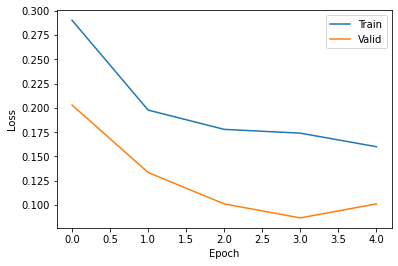

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
!pip install azureml-core

     |████████████████████████████████| 2.5 MB 29.6 MB/s 
     |████████████████████████████████| 211 kB 61.1 MB/s 
     |████████████████████████████████| 146 kB 64.5 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 928 kB 69.4 MB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
     |████████████████████████████████| 2.3 MB 57.1 MB/s 
     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 40 kB 3.0 MB/s 
     |████████████████████████████████| 141 kB 4.3 MB/s 
     |████████████████████████████████| 79 kB 2.7 MB/s 
     |████████████████████████████████| 3.6 MB 26.6 MB/s 
     |████████████████████████████████| 1.8 MB 64.5 MB/s 
     |████████████████████████████████| 59 kB 3.0 MB/s 
     |████████████████████████████████| 412 kB 4.3 MB/s 
     |██████████████████████████

In [ ]:
# Function to plot the confusion matrix 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import time
import torch.nn as nn
import json
# import torch.optim as optim
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
# from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score, 
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
import matplotlib.pyplot as plt
from azureml.core import Workspace, Run, Dataset
from azureml.core.model import Model
import warnings
warnings.filterwarnings("ignore")

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# pass the pre-trained BERT to our define architecture
test_model = BERT_Arch(bert)
test_model = test_model.to(device)
test_model.load_state_dict(torch.load('saved_weights.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:


with torch.no_grad():
  pred_proba = test_model(test_seq.to(device), test_mask.to(device))
  pred_proba = pred_proba.detach().cpu().numpy()

preds = np.argmax(pred_proba, axis = 1)

print([preds.tolist(), pred_proba.tolist()])

[[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,

In [ ]:
test_y = test_y.reshape(8980,)
test_y.shape

torch.Size([8980])

In [ ]:
test_y1 = test_y[:8980]
test_y1 = test_y1.reshape(8980)
test_y1 = np.asarray(test_y1)
test_y1.shape

(8980,)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(test_y1, preds)) # Value between 0 and 1

print("Accuracy Percentage {} %:".format(100*accuracy_score(test_y, preds))) # Value between 0 and 100

Accuracy: 0.9661469933184855
Accuracy Percentage 96.61469933184856 %:


Confusion matrix, without normalization


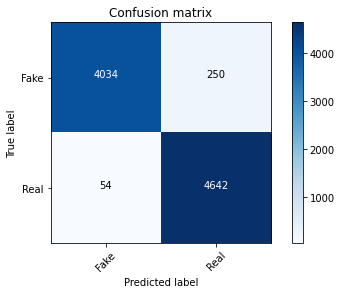

In [ ]:
cm = metrics.confusion_matrix(test_y1, preds)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])